# Phase 1: Station Boundary Detection

This notebook identifies distinct stations/zones where individuals spend time during the workshop using clustering algorithms.

**Important:** Each "group" represents one individual person. Multiple people move through stations, but each person is at only one station at a time, and no two people occupy the same station simultaneously.

## Objectives:
- Visualize raw RTLS data
- Apply K-Means clustering to identify stations
- Define station boundaries using 1.5σ bounding boxes
- Classify data points as "at station" or "traveling"
- Export station centroids and assignments

## Output:
- Station centroids (coordinates)
- Station bounding boxes (1.5σ)
- Data with station assignments and point classification
- Clustering model and scaler

## Workshop Selection

In [15]:
# ============================================
# WORKSHOP SELECTION
# ============================================
# Change this to analyze a different workshop
# Valid options: "Workshop1", "Workshop2", "Workshop3"

WORKSHOP = "Workshop1"  # 👈 CHANGE THIS VALUE

# ============================================

print(f"🎯 Selected Workshop: {WORKSHOP}")
print(f"{'='*50}")
print(f"This analysis will run on {WORKSHOP} data only.")
print(f"{'='*50}\n")

🎯 Selected Workshop: Workshop1
This analysis will run on Workshop1 data only.



## Setup and Data Loading

In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [17]:
# Load data for the selected workshop
data_file = f'../data/raw/{WORKSHOP}.csv'

print(f"Loading data from: {data_file}")
df = pd.read_csv(data_file)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Sort by person (name) and time
df = df.sort_values(['name', 'time']).reset_index(drop=True)

print(f"\n{'='*60}")
print(f"📊 {WORKSHOP} Dataset Summary")
print(f"{'='*60}")
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date Range: {df['time'].min()} to {df['time'].max()}")
print(f"Individuals (groups) in this workshop: {sorted(df['name'].unique())}")
print(f"Number of individuals: {df['name'].nunique()}")
print(f"Total Data Points: {len(df):,}")
print(f"{'='*60}\n")

df.head(10)

Loading data from: ../data/raw/Workshop1.csv

📊 Workshop1 Dataset Summary
Dataset Shape: (19905, 5)
Columns: ['name', 'x', 'y', 'z', 'time']
Date Range: 2025-07-11 12:50:27.614230 to 2025-07-11 15:47:23.751670
Individuals (groups) in this workshop: ['Group 1', 'Group 2', 'Group 3', 'Group 5', 'Group 6', 'group 4']
Number of individuals: 6
Total Data Points: 19,905



,name,x,y,z,time
0,Group 1,40.61,13.18,-3.28,2025-07-11 12:50:27.682198
1,Group 1,40.62,13.12,-3.36,2025-07-11 12:50:28.450802
2,Group 1,40.62,13.21,-3.43,2025-07-11 12:50:29.450425
3,Group 1,40.79,13.22,-3.35,2025-07-11 12:50:30.450321
4,Group 1,40.78,13.23,-3.27,2025-07-11 12:50:31.450763
5,Group 1,40.90,13.18,-3.42,2025-07-11 12:50:32.450341
6,Group 1,40.60,13.11,-3.31,2025-07-11 12:50:37.452409
7,Group 1,40.58,13.06,-3.40,2025-07-11 12:50:38.450288
8,Group 1,40.77,13.07,-3.26,2025-07-11 12:50:39.449936
9,Group 1,40.82,13.10,-3.16,2025-07-11 12:50:40.450137


In [18]:
# Basic data exploration
print("Coordinate Statistics:")
print(df[['x', 'y', 'z']].describe())

print("\nData Points per Individual (Group):")
print(df.groupby('name').size().to_frame('count'))

Coordinate Statistics:
                  x             y             z
count  19905.000000  19905.000000  19905.000000
mean      37.606728     13.942585     -0.765839
std        3.412498      3.532556      2.735904
min       28.120000      4.530000     -6.550000
25%       34.830000     10.070000     -3.030000
50%       38.230000     14.570000     -1.420000
75%       40.600000     16.630000      1.480000
max       45.300000     22.950000      6.160000

Data Points per Individual (Group):
         count
name          
Group 1   3388
Group 2   5083
Group 3   5358
Group 5   2723
Group 6   2205
group 4   1148


## 1.1 Visualize Raw Data

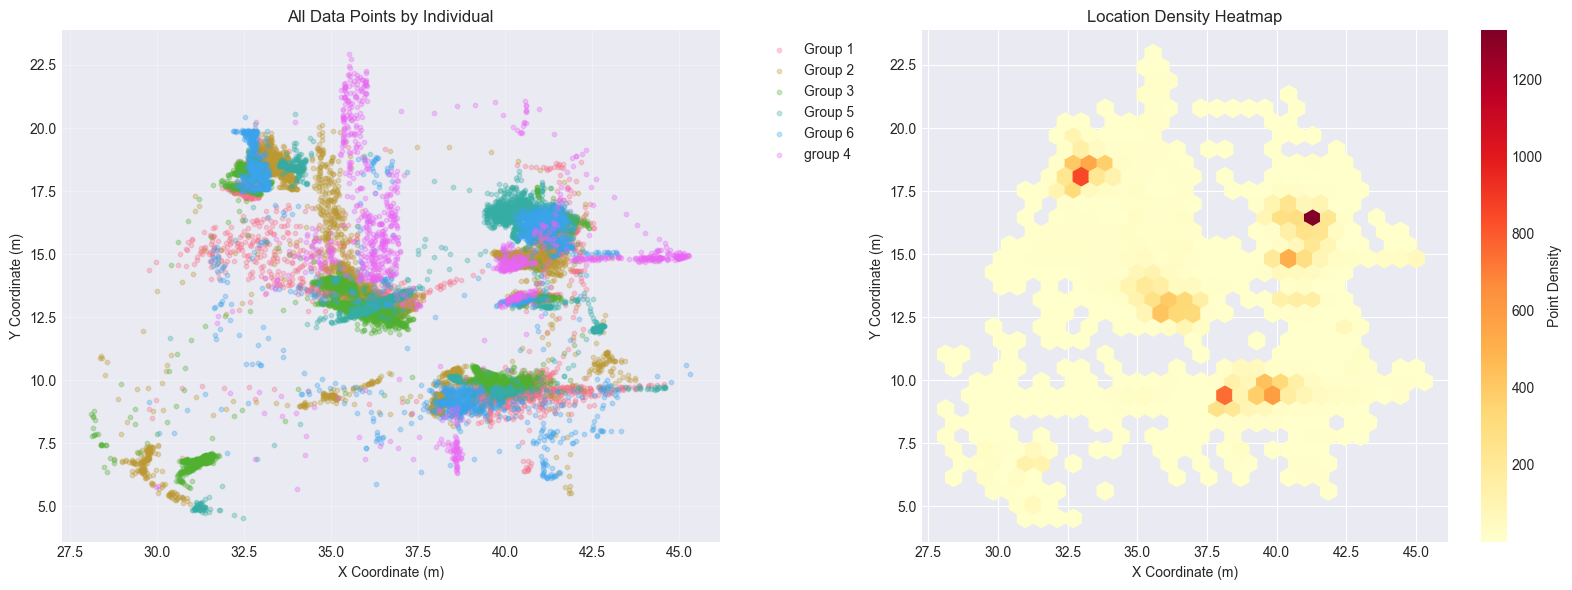

High-density areas likely represent stations where individuals spent significant time.


In [19]:
# Visualize all data points in 2D space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All points colored by individual (group)
for group in df['name'].unique():
    group_data = df[df['name'] == group]
    axes[0].scatter(group_data['x'], group_data['y'], alpha=0.3, s=10, label=group)
axes[0].set_xlabel('X Coordinate (m)')
axes[0].set_ylabel('Y Coordinate (m)')
axes[0].set_title('All Data Points by Individual')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Density heatmap
axes[1].hexbin(df['x'], df['y'], gridsize=30, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('X Coordinate (m)')
axes[1].set_ylabel('Y Coordinate (m)')
axes[1].set_title('Location Density Heatmap')
plt.colorbar(axes[1].collections[0], ax=axes[1], label='Point Density')

plt.tight_layout()
plt.show()

print("High-density areas likely represent stations where individuals spent significant time.")

## 1.2 K-Means Clustering: Find Optimal Number of Stations

In [20]:
# Prepare clustering data (use X, Y coordinates)
coords = df[['x', 'y']].values

# Standardize coordinates for better clustering
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Sample data for faster computation (if dataset is large)
sample_size = min(20000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)
coords_sample = coords_scaled[sample_idx]

print(f"Using {sample_size:,} sample points for optimal k analysis")

Using 19,905 sample points for optimal k analysis


k=2: Inertia=22098.11, Silhouette=0.447
k=3: Inertia=11355.78, Silhouette=0.562
k=3: Inertia=11355.78, Silhouette=0.562
k=4: Inertia=6551.73, Silhouette=0.651
k=4: Inertia=6551.73, Silhouette=0.651
k=5: Inertia=3312.37, Silhouette=0.693
k=5: Inertia=3312.37, Silhouette=0.693
k=6: Inertia=2802.05, Silhouette=0.625
k=6: Inertia=2802.05, Silhouette=0.625
k=7: Inertia=2368.23, Silhouette=0.581
k=7: Inertia=2368.23, Silhouette=0.581
k=8: Inertia=2101.98, Silhouette=0.542
k=8: Inertia=2101.98, Silhouette=0.542
k=9: Inertia=1885.29, Silhouette=0.552
k=9: Inertia=1885.29, Silhouette=0.552
k=10: Inertia=1696.80, Silhouette=0.542
k=10: Inertia=1696.80, Silhouette=0.542
k=11: Inertia=1535.48, Silhouette=0.552
k=11: Inertia=1535.48, Silhouette=0.552
k=12: Inertia=1401.39, Silhouette=0.546
k=12: Inertia=1401.39, Silhouette=0.546
k=13: Inertia=1297.45, Silhouette=0.529
k=13: Inertia=1297.45, Silhouette=0.529
k=14: Inertia=1168.06, Silhouette=0.544
k=14: Inertia=1168.06, Silhouette=0.544
k=15: Inerti

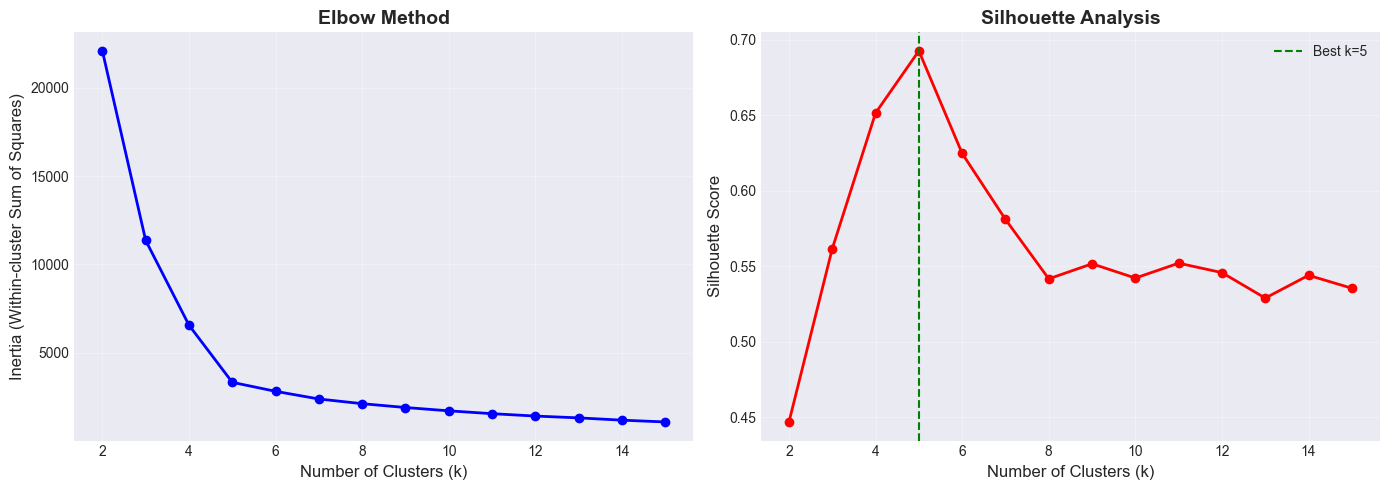


✅ Recommended number of stations (clusters): 5
   Silhouette score: 0.693


In [21]:
# Elbow method and silhouette analysis
k_range = range(2, 16)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(coords_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(coords_sample, labels))
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-', linewidth=2)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k_silhouette, color='green', linestyle='--', label=f'Best k={best_k_silhouette}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Recommended number of stations (clusters): {best_k_silhouette}")
print(f"   Silhouette score: {max(silhouette_scores):.3f}")

## 1.3 Apply K-Means with Optimal k

In [22]:
# Use the optimal k (or manually set based on domain knowledge)
optimal_k = best_k_silhouette  # You can override this: optimal_k = 6

# Fit K-Means on full dataset
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['station'] = kmeans.fit_predict(coords_scaled)

# Get station centroids in original scale
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Create station info dataframe
station_info = pd.DataFrame({
    'station': range(optimal_k),
    'centroid_x': centroids_original[:, 0],
    'centroid_y': centroids_original[:, 1]
})

print("Station Centroids:")
print(station_info)
print(f"\nPoints per station:")
print(df['station'].value_counts().sort_index())

Station Centroids:
   station  centroid_x  centroid_y
0        0   30.856141    6.876729
1        1   41.047488   15.639159
2        2   33.284963   18.213026
3        3   35.960025   13.268907
4        4   39.486926    9.439034

Points per station:
station
0     697
1    6152
2    4297
3    4071
4    4688
Name: count, dtype: int64


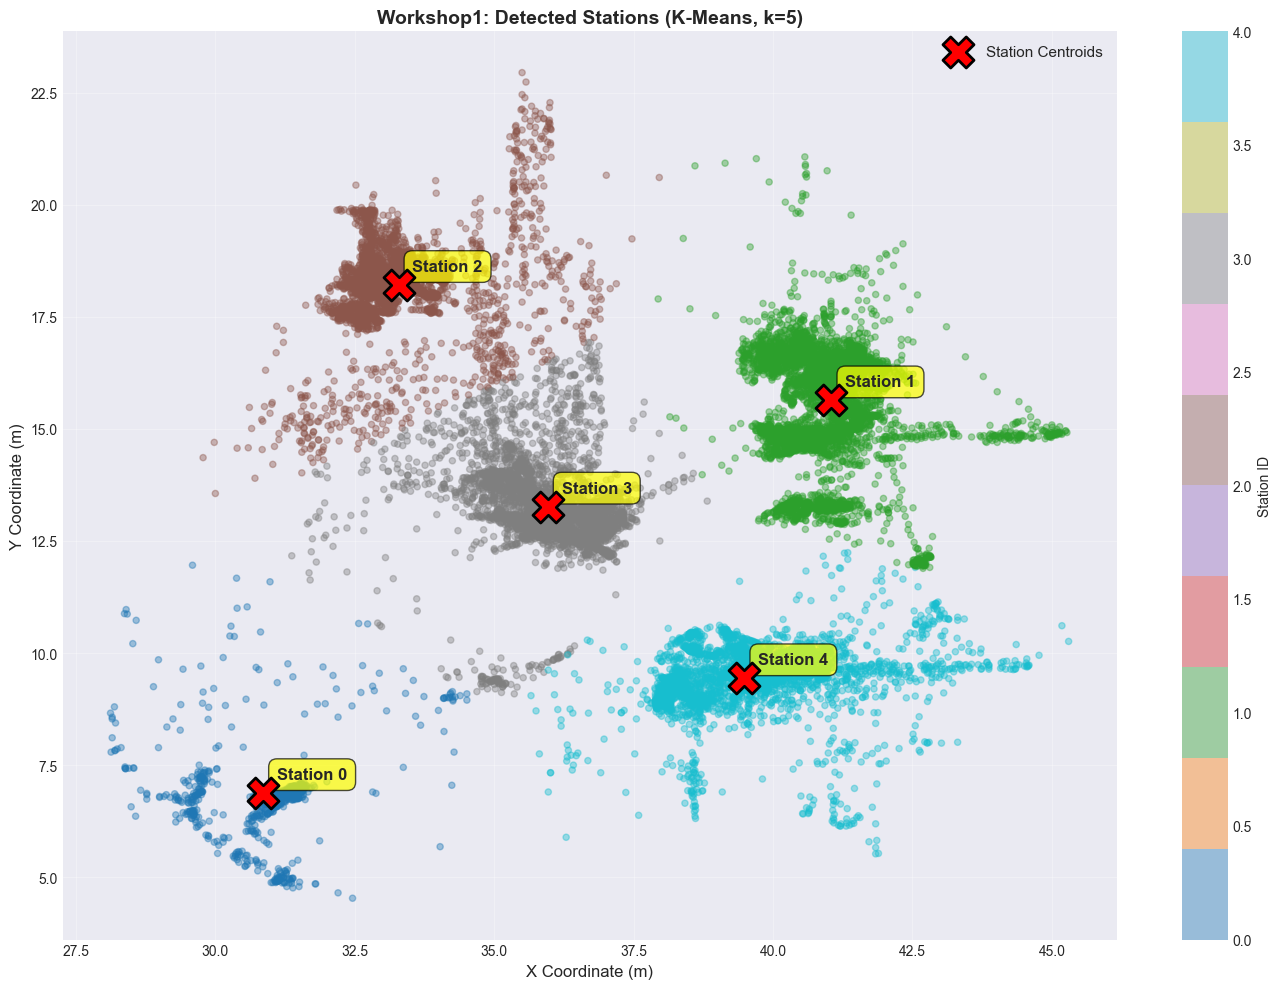

In [23]:
# Visualize stations
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all points colored by station
scatter = ax.scatter(df['x'], df['y'], c=df['station'], cmap='tab10', alpha=0.4, s=20)

# Plot centroids
ax.scatter(station_info['centroid_x'], station_info['centroid_y'], 
           c='red', marker='X', s=500, edgecolors='black', linewidths=2,
           label='Station Centroids', zorder=5)

# Add station labels
for idx, row in station_info.iterrows():
    ax.annotate(f'Station {idx}', 
                xy=(row['centroid_x'], row['centroid_y']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.set_xlabel('X Coordinate (m)', fontsize=12)
ax.set_ylabel('Y Coordinate (m)', fontsize=12)
ax.set_title(f'{WORKSHOP}: Detected Stations (K-Means, k={optimal_k})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Station ID')
plt.tight_layout()
plt.show()

## 1.3.1 Define Station Bounding Boxes (1.5σ Method)

Create precise station boundaries using 1.5 standard deviations. Points outside these boundaries are classified as "traveling" between stations.

In [24]:
# Calculate bounding boxes for each station using 1.5 standard deviations
SIGMA_MULTIPLIER = 1.5  # Bounding box coverage: ±1.5σ

station_bounds = []

for station_id in range(optimal_k):
    station_data = df[df['station'] == station_id]
    
    # Calculate mean and standard deviation for x and y
    mean_x = station_data['x'].mean()
    mean_y = station_data['y'].mean()
    std_x = station_data['x'].std()
    std_y = station_data['y'].std()
    
    # Bounding box with 1.5 standard deviations
    bounds = {
        'station': station_id,
        'centroid_x': mean_x,
        'centroid_y': mean_y,
        'std_x': std_x,
        'std_y': std_y,
        'x_min': mean_x - SIGMA_MULTIPLIER * std_x,
        'x_max': mean_x + SIGMA_MULTIPLIER * std_x,
        'y_min': mean_y - SIGMA_MULTIPLIER * std_y,
        'y_max': mean_y + SIGMA_MULTIPLIER * std_y,
        'width': 2 * SIGMA_MULTIPLIER * std_x,  # 1.5σ on each side
        'height': 2 * SIGMA_MULTIPLIER * std_y,
        'area': (2 * SIGMA_MULTIPLIER * std_x) * (2 * SIGMA_MULTIPLIER * std_y),
        'num_points': len(station_data)
    }
    station_bounds.append(bounds)

station_bounds_df = pd.DataFrame(station_bounds)

print(f"Station Bounding Boxes ({SIGMA_MULTIPLIER}σ method):")
print("=" * 80)
print(station_bounds_df.to_string(index=False))
print(f"\n💡 These bounding boxes capture ~{86.6:.1f}% of points at each station (±{SIGMA_MULTIPLIER}σ)")
print(f"   Tighter boundaries = more points classified as 'traveling'")

Station Bounding Boxes (1.5σ method):
 station  centroid_x  centroid_y    std_x    std_y     x_min     x_max     y_min     y_max    width   height      area  num_points
       0   30.856141    6.876729 1.100900 1.163435 29.204791 32.507490  5.131576  8.621882 3.302699 3.490306 11.527430         697
       1   41.047017   15.639099 0.831913 1.226547 39.799148 42.294886 13.799279 17.478920 2.495738 3.679640  9.183419        6152
       2   33.285441   18.212548 0.902472 0.973629 31.931733 34.639149 16.752105 19.672992 2.707416 2.920887  7.908057        4297
       3   35.959639   13.267706 0.884848 1.030955 34.632367 37.286911 11.721273 14.814139 2.654544 3.092866  8.210147        4071
       4   39.486926    9.439034 1.270580 0.653306 37.581056 41.392796  8.459074 10.418993 3.811740 1.959919  7.470702        4688

💡 These bounding boxes capture ~86.6% of points at each station (±1.5σ)
   Tighter boundaries = more points classified as 'traveling'


In [25]:
# Classify points as "at_station" or "traveling"
def point_in_station_bounds(row, bounds_df):
    """
    Check if a point is within the 1.5σ bounding box of its assigned station.
    """
    station_id = row['station']
    bounds = bounds_df[bounds_df['station'] == station_id].iloc[0]
    
    x_in_bounds = bounds['x_min'] <= row['x'] <= bounds['x_max']
    y_in_bounds = bounds['y_min'] <= row['y'] <= bounds['y_max']
    
    return x_in_bounds and y_in_bounds

# Apply classification
df['at_station'] = df.apply(lambda row: point_in_station_bounds(row, station_bounds_df), axis=1)
df['point_type'] = df['at_station'].map({True: 'at_station', False: 'traveling'})

# Summary statistics
print("Point Classification Summary:")
print("=" * 80)
print(f"Total points: {len(df):,}")
print(f"Points at stations (within {SIGMA_MULTIPLIER}σ): {df['at_station'].sum():,} ({df['at_station'].sum()/len(df)*100:.1f}%)")
print(f"Traveling points (outside {SIGMA_MULTIPLIER}σ): {(~df['at_station']).sum():,} ({(~df['at_station']).sum()/len(df)*100:.1f}%)")

print("\nBreakdown by station:")
for station_id in range(optimal_k):
    station_mask = df['station'] == station_id
    at_station_count = (station_mask & df['at_station']).sum()
    total_assigned = station_mask.sum()
    print(f"  Station {station_id}: {at_station_count:,}/{total_assigned:,} points within bounds "
          f"({at_station_count/total_assigned*100:.1f}%)")

Point Classification Summary:
Total points: 19,905
Points at stations (within 1.5σ): 16,619 (83.5%)
Traveling points (outside 1.5σ): 3,286 (16.5%)

Breakdown by station:
  Station 0: 534/697 points within bounds (76.6%)
  Station 1: 5,040/6,152 points within bounds (81.9%)
  Station 2: 3,578/4,297 points within bounds (83.3%)
  Station 3: 3,395/4,071 points within bounds (83.4%)
  Station 4: 4,072/4,688 points within bounds (86.9%)


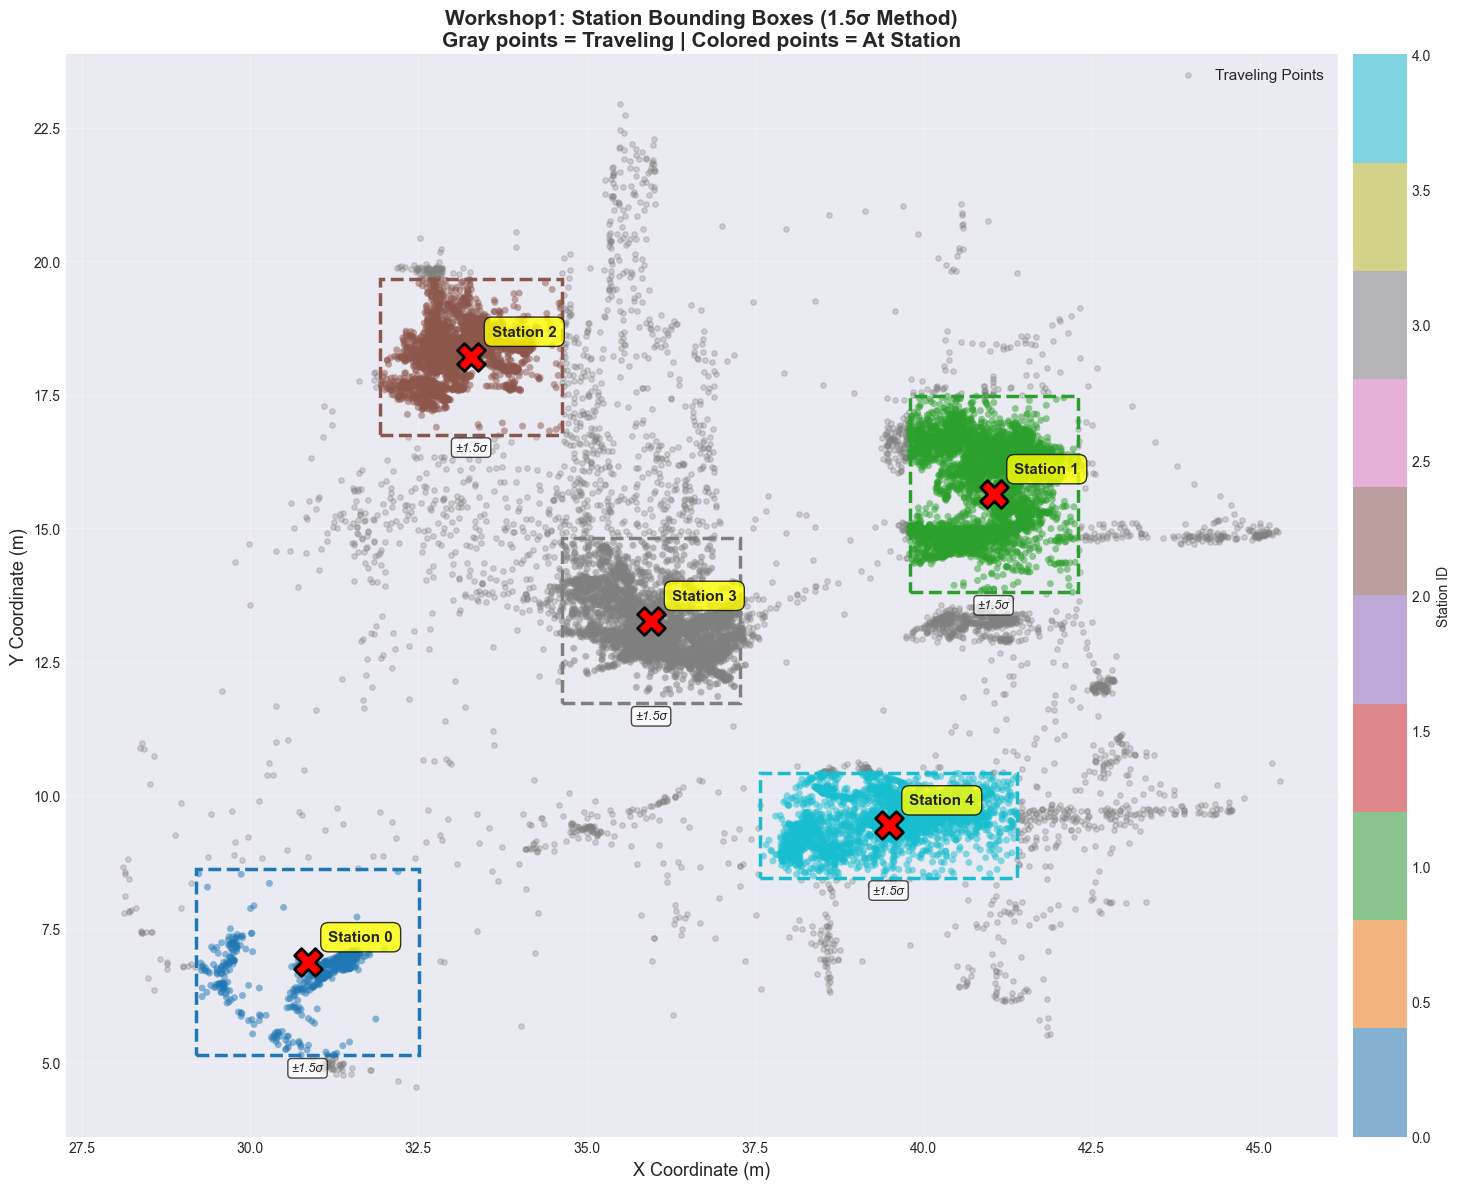


📦 Dashed rectangles show 1.5σ bounding boxes for each station
   Points inside boxes = at station | Points outside = traveling


In [26]:
# Visualize bounding boxes with data points
fig, ax = plt.subplots(figsize=(16, 12))

# Plot traveling points (outside bounding boxes) in gray
traveling_points = df[~df['at_station']]
ax.scatter(traveling_points['x'], traveling_points['y'], 
           c='gray', alpha=0.3, s=15, label='Traveling Points', zorder=1)

# Plot points at stations with colors
at_station_points = df[df['at_station']]
scatter = ax.scatter(at_station_points['x'], at_station_points['y'], 
                     c=at_station_points['station'], cmap='tab10', 
                     alpha=0.5, s=25, edgecolors='none', zorder=2)

# Draw bounding boxes for each station
from matplotlib.patches import Rectangle
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for idx, row in station_bounds_df.iterrows():
    # Draw rectangle (1.5σ bounding box)
    rect = Rectangle(
        (row['x_min'], row['y_min']),
        row['width'],
        row['height'],
        linewidth=2.5,
        edgecolor=colors[idx],
        facecolor='none',
        linestyle='--',
        zorder=3
    )
    ax.add_patch(rect)
    
    # Add station label at centroid
    ax.scatter(row['centroid_x'], row['centroid_y'], 
               c='red', marker='X', s=400, edgecolors='black', 
               linewidths=2, zorder=5)
    
    ax.annotate(f'Station {int(row["station"])}', 
                xy=(row['centroid_x'], row['centroid_y']),
                xytext=(15, 15), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                zorder=6)
    
    # Add dimension annotations
    ax.text(row['centroid_x'], row['y_min'] - 0.3, 
            f"±{SIGMA_MULTIPLIER}σ", 
            ha='center', fontsize=9, style='italic',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('X Coordinate (m)', fontsize=13)
ax.set_ylabel('Y Coordinate (m)', fontsize=13)
ax.set_title(f'{WORKSHOP}: Station Bounding Boxes ({SIGMA_MULTIPLIER}σ Method)\n'
             f'Gray points = Traveling | Colored points = At Station', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Station ID', pad=0.01)
plt.tight_layout()
plt.show()

print(f"\n📦 Dashed rectangles show {SIGMA_MULTIPLIER}σ bounding boxes for each station")
print("   Points inside boxes = at station | Points outside = traveling")

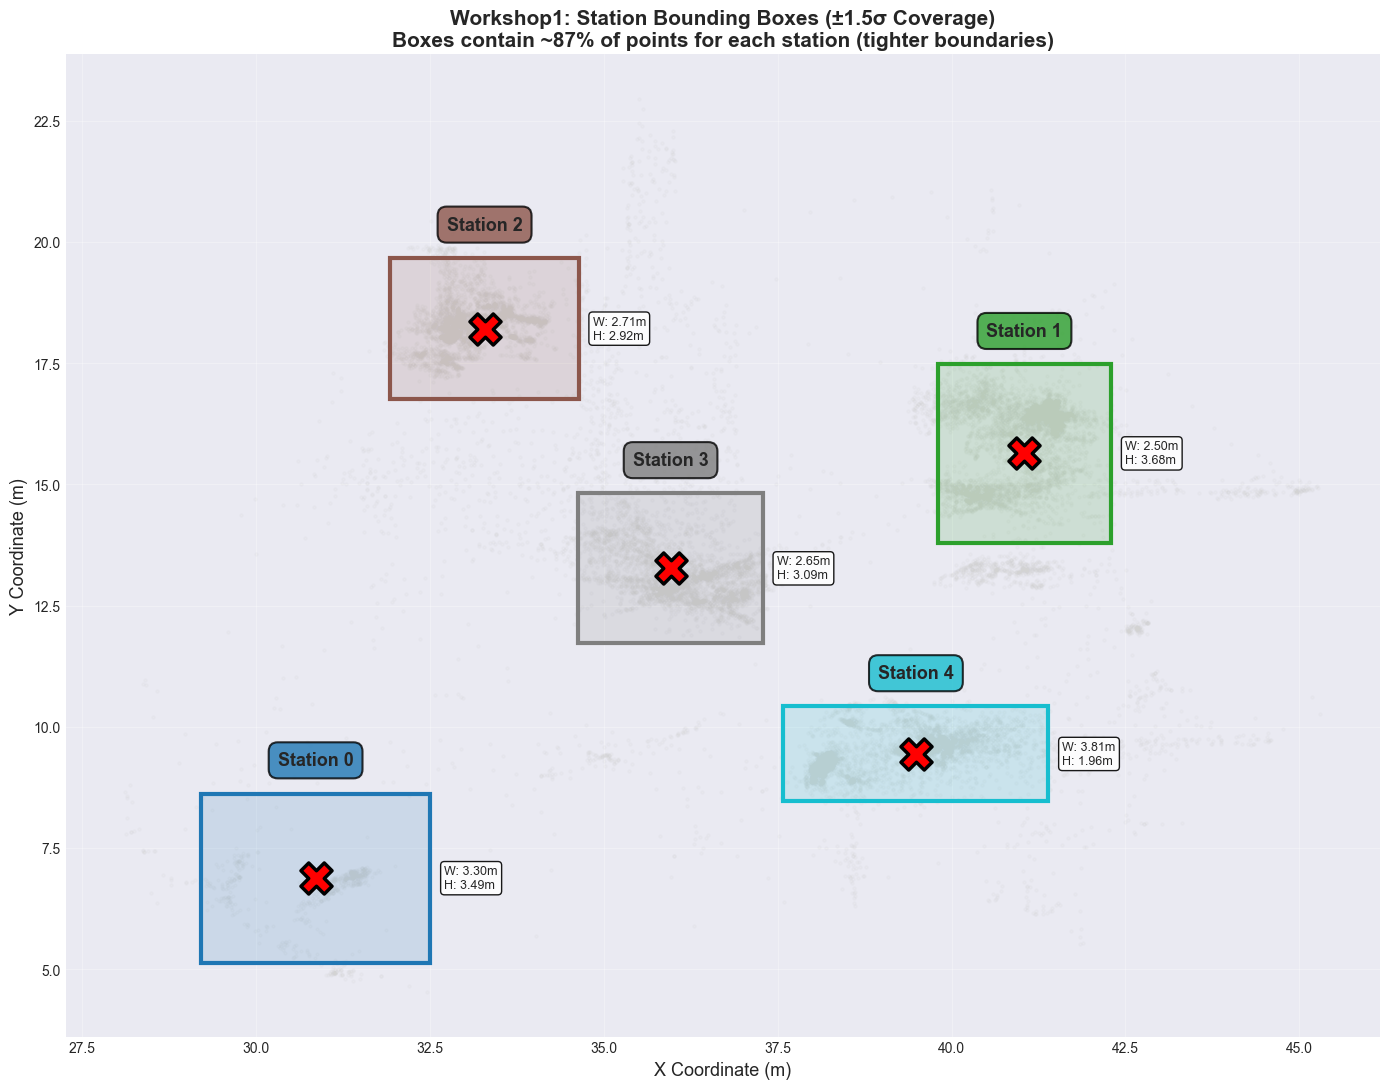


📊 Bounding Box Details:
 station  centroid_x  centroid_y    width   height      area
       0   30.856141    6.876729 3.302699 3.490306 11.527430
       1   41.047017   15.639099 2.495738 3.679640  9.183419
       2   33.285441   18.212548 2.707416 2.920887  7.908057
       3   35.959639   13.267706 2.654544 3.092866  8.210147
       4   39.486926    9.439034 3.811740 1.959919  7.470702


In [27]:
# Create a cleaner visualization showing just bounding boxes and centroids
fig, ax = plt.subplots(figsize=(14, 11))

# Draw all data points with low opacity
ax.scatter(df['x'], df['y'], c='lightgray', alpha=0.1, s=5, zorder=1)

# Draw bounding boxes
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for idx, row in station_bounds_df.iterrows():
    color = colors[idx]
    
    # Draw filled rectangle with transparency
    rect_filled = Rectangle(
        (row['x_min'], row['y_min']),
        row['width'],
        row['height'],
        linewidth=0,
        edgecolor='none',
        facecolor=color,
        alpha=0.15,
        zorder=2
    )
    ax.add_patch(rect_filled)
    
    # Draw rectangle border
    rect_border = Rectangle(
        (row['x_min'], row['y_min']),
        row['width'],
        row['height'],
        linewidth=3,
        edgecolor=color,
        facecolor='none',
        linestyle='-',
        zorder=3
    )
    ax.add_patch(rect_border)
    
    # Draw centroid
    ax.scatter(row['centroid_x'], row['centroid_y'], 
               c='red', marker='X', s=500, edgecolors='black', 
               linewidths=2.5, zorder=5)
    
    # Add station label
    ax.text(row['centroid_x'], row['centroid_y'] + row['height']/2 + 0.5, 
            f'Station {int(row["station"])}',
            ha='center', va='bottom',
            fontsize=13, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.8, edgecolor='black', linewidth=1.5),
            zorder=6)
    
    # Add dimensions
    ax.text(row['x_max'] + 0.2, row['centroid_y'], 
            f'W: {row["width"]:.2f}m\nH: {row["height"]:.2f}m',
            va='center', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

ax.set_xlabel('X Coordinate (m)', fontsize=13)
ax.set_ylabel('Y Coordinate (m)', fontsize=13)
ax.set_title(f'{WORKSHOP}: Station Bounding Boxes (±{SIGMA_MULTIPLIER}σ Coverage)\n'
             f'Boxes contain ~87% of points for each station (tighter boundaries)', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Bounding Box Details:")
print(station_bounds_df[['station', 'centroid_x', 'centroid_y', 'width', 'height', 'area']].to_string(index=False))

## Save Phase 1 Results

In [28]:
# Create output directory for this workshop
output_dir = Path(f'../data/phase1_results/{WORKSHOP}')
output_dir.mkdir(parents=True, exist_ok=True)

# Save data with station assignments and point classification
df[['name', 'x', 'y', 'z', 'time', 'station', 'at_station', 'point_type']].to_csv(
    output_dir / 'data_with_stations.csv', index=False
)

# Save station centroids
station_info.to_csv(output_dir / 'station_centroids.csv', index=False)

# Save station bounding boxes
station_bounds_df.to_csv(output_dir / 'station_bounding_boxes.csv', index=False)

# Save K-Means model and scaler
with open(output_dir / 'kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open(output_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save metadata
metadata = {
    'workshop': WORKSHOP,
    'optimal_k': optimal_k,
    'silhouette_score': max(silhouette_scores),
    'sigma_multiplier': SIGMA_MULTIPLIER,
    'total_data_points': len(df),
    'points_at_station': df['at_station'].sum(),
    'points_traveling': (~df['at_station']).sum(),
    'percent_at_station': df['at_station'].sum() / len(df) * 100
}
pd.DataFrame([metadata]).to_csv(output_dir / 'phase1_metadata.csv', index=False)

print(f"✅ Phase 1 results saved to {output_dir}/")
print(f"\nSaved files:")
print(f"  • data_with_stations.csv - Data with station assignments and point classification")
print(f"  • station_centroids.csv - Station centroid coordinates")
print(f"  • station_bounding_boxes.csv - {SIGMA_MULTIPLIER}σ bounding boxes for each station")
print(f"  • kmeans_model.pkl - Trained K-Means model")
print(f"  • scaler.pkl - StandardScaler for coordinates")
print(f"  • phase1_metadata.csv - Clustering metadata")
print(f"\n📊 Point Classification ({SIGMA_MULTIPLIER}σ boundaries):")
print(f"  • At station (within {SIGMA_MULTIPLIER}σ): {df['at_station'].sum():,} points ({metadata['percent_at_station']:.1f}%)")
print(f"  • Traveling (outside {SIGMA_MULTIPLIER}σ): {(~df['at_station']).sum():,} points ({100-metadata['percent_at_station']:.1f}%)")
print(f"\n🎯 Proceed to phase2_temporal_analysis.ipynb")

✅ Phase 1 results saved to ../data/phase1_results/Workshop1/

Saved files:
  • data_with_stations.csv - Data with station assignments and point classification
  • station_centroids.csv - Station centroid coordinates
  • station_bounding_boxes.csv - 1.5σ bounding boxes for each station
  • kmeans_model.pkl - Trained K-Means model
  • scaler.pkl - StandardScaler for coordinates
  • phase1_metadata.csv - Clustering metadata

📊 Point Classification (1.5σ boundaries):
  • At station (within 1.5σ): 16,619 points (83.5%)
  • Traveling (outside 1.5σ): 3,286 points (16.5%)

🎯 Proceed to phase2_temporal_analysis.ipynb
